In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ollama  # LLaMA model API
import re
from tqdm import tqdm  # For progress bars
from concurrent.futures import ThreadPoolExecutor, as_completed  # For parallel processing
from gnews import GNews  # Import the GNews package
from pytz import UTC

### Downloading historic asset price from yfinance

In [3]:
# Fetch Historical Prices
def fetch_all_historical_prices(asset_symbol, start_date, end_date):
    try:
        data = yf.download(
            asset_symbol,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            progress=False
        )
        if data.empty:
            raise ValueError(f"No data found for {asset_symbol} between {start_date} and {end_date}.")
        data = data[['Close']].rename(columns={'Close': asset_symbol})
        data.columns = [asset_symbol]
        return data
    except Exception as e:
        print(f"Error fetching data for {asset_symbol}: {e}")
        return pd.DataFrame()

### Downloading historic asset news from Gnews

In [5]:
# Fetch News using GNews
def fetch_all_google_news(query, start_date, end_date):
    gnews = GNews(language='en', country='US', max_results=5)  # Limit to top 5 headlines
    all_news_list = []

    # Generate date ranges
    date_ranges = pd.date_range(start_date, end_date, freq='D')

    for date in tqdm(date_ranges, desc="Fetching news data"):
        date_str = date.strftime('%Y-%m-%d')
        try:
            # Fetch articles for the specific date
            articles = gnews.get_news(f"{query} after:{date_str} before:{(date + timedelta(days=1)).strftime('%Y-%m-%d')}")
            if articles:
                unique_titles = [article.get('title', 'No Title') for article in articles[:5]]  # Top 5 headlines
                news_content = " ".join(unique_titles)
                news_content = news_content[:500]  # Limit news content to 500 characters
                all_news_list.append({
                    "Date": date,
                    "News": news_content
                })
        except Exception as e:
            print(f"Error fetching news for {date_str}: {e}")

    # Create DataFrame from the list
    all_news = pd.DataFrame(all_news_list)
    all_news.drop_duplicates(subset=["Date"], inplace=True)
    all_news.set_index('Date', inplace=True)
    return all_news

### Load data locally or Fetch Data from yfinance & Gnews

In [7]:
# Load or Fetch Data
def load_or_fetch_data(asset_symbol, query, start_date, end_date):
    # Fetch or load historical prices
    if not os.path.exists(f"{asset_symbol}_historical_prices.csv"):
        print("Fetching historical prices...")
        historical_prices = fetch_all_historical_prices(asset_symbol, start_date, end_date)
        historical_prices.to_csv(f"{asset_symbol}_historical_prices.csv", index=True)
        print(f"Historical prices saved to '{asset_symbol}_historical_prices.csv'.")
    else:
        print("Loading existing historical prices...")
        historical_prices = pd.read_csv(
            f"{asset_symbol}_historical_prices.csv",
            parse_dates=["Date"],
            index_col="Date"
        )

        # Ensure the correct column name
        if asset_symbol not in historical_prices.columns:
            raise ValueError(f"The expected column '{asset_symbol}' was not found in '{asset_symbol}_historical_prices.csv'.")

        historical_prices = historical_prices[[asset_symbol]]  # Select the column for the asset

    # Fetch or load news data
    if not os.path.exists(f"{asset_symbol}_news_data.csv"):
        print("Fetching news data...")
        news_data = fetch_all_google_news(query, start_date, end_date)
        news_data.to_csv(f"{asset_symbol}_news_data.csv", index=True)
        print(f"News data saved to '{asset_symbol}_news_data.csv'.")
    else:
        print("Loading existing news data...")
        news_data = pd.read_csv(
            f"{asset_symbol}_news_data.csv",
            parse_dates=["Date"],
            index_col="Date"
        )

    return historical_prices, news_data

In [8]:
# Get the date using index difference.
def LastMarketOpen_DateDiff(df, curr_date, delta):
    '''Index of the dataframe is pandas datetime format. In case date is a column in dataframe use timedelta toget the difference.'''
    curr_date_index = df.index.get_loc(curr_date)
    final_date = pd.to_datetime(df.iloc[curr_date_index+(delta)].name)
    return (final_date)

### Given one slice of input data making n-simulated predictions.
- Instead of taking past m days window size, here we will take past m indexes because some stock exchanges remain closed on holidays.
- News data for each market open day should be the cummulation of all news which came after the last market day till the current day.

In [10]:
# Predict Next Day's Price with LLaMA (Probabilistic) including news
def predict_next_price_probabilistic(
    asset_symbol,
    current_date,
    historical_prices,
    news_data,
    window_size,
    n_simulations,
    quantiles=(0.05, 0.5, 0.95)
):

    # current_date_index = historical_prices.index.get_loc(current_date)
    # start_date = pd.to_datetime(historical_prices.iloc[current_date_index-(window_size - 1)].name)     # current_date - timedelta(days=window_size - 1)
    start_date = LastMarketOpen_DateDiff(historical_prices, current_date, -(window_size - 1))
    historical_window = historical_prices.loc[start_date:current_date].dropna().values.flatten()

    if len(historical_window) < window_size:
        print(f"Insufficient data for prediction on {current_date.date()}.")
        return None, None, None

    historical_prices_str = ", ".join(f"{x:.2f}" for x in historical_window)
    predictions = []

    # Get news data from the last market open date to current_date
    prev_hp_date = LastMarketOpen_DateDiff(historical_prices, current_date, -1)
    # curr_dt_index = news_data.index.get_loc(current_date)
    # prev_dt_index = news_data.index.get_loc(LastMarketOpen_DateDiff(historical_prices, current_date, -1))

    print(current_date, prev_hp_date)
    if current_date - prev_hp_date == timedelta(days=1):
        news_content = news_data.loc[current_date, 'News'] if current_date in news_data.index else "No significant news."
    else:
        news_content = news_data.loc[prev_hp_date:current_date+timedelta(days=1), 'News'].sum() if current_date in news_data.index else "No significant news."
        print(news_content)

    prompt = (
        f"Given this data:\n"
        f"Historical prices for {asset_symbol} over the past {window_size} days:\n"
        f"{historical_prices_str}\n"
        f"Recent news headlines related to {asset_symbol}:\n"
        f"{news_content}\n"
        f"Based on the historical prices and recent news, predict the price for {asset_symbol} for the next day.\n"
        f"Provide your prediction as a single number (e.g., 38500). Do not include any text other than the number."
    )

    def run_simulation(_):
        try:
            response = ollama.chat(
                model="llama3.3",
                messages=[
                    {"role": "system", "content": "You are a financial forecasting assistant."},
                    {"role": "user", "content": prompt}
                ]
            )
            response_content = response["message"]["content"]
            match = re.search(r"[\$]?[0-9,]+\.?[0-9]*", response_content)
            if match:
                return float(match.group().replace(",", "").replace("$", ""))
        except Exception as e:
            print(f"LLaMA simulation failed: {e}")
        return None

    max_workers = min(10, n_simulations)  # Limit number of threads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(run_simulation, _) for _ in range(n_simulations)]
        for future in tqdm(
            as_completed(futures),
            total=n_simulations,
            desc=f"Simulating {n_simulations} predictions for {current_date.date()}"
        ):
            result = future.result()
            if result is not None:
                predictions.append(result)

    if len(predictions) == 0:
        print(f"No valid predictions generated for {current_date}.")
        return None, None, None

    # Calculate quantiles
    quantile_values = np.quantile(predictions, quantiles)
    return quantile_values[0], quantile_values[1], quantile_values[2]

### Making predictions on a roling window from start_date to end_date

In [12]:
# Rolling Predictions with Probabilistic Forecasting including news
def rolling_window_price_predictions_probabilistic(
    asset_symbol,
    historical_prices,
    news_data,
    start_date,
    end_date,
    window_size,
    n_simulations
):
    historical_prices.index = pd.to_datetime(historical_prices.index).normalize().tz_localize(None)
    news_data.index = pd.to_datetime(news_data.index).normalize()
    # Adjust start_date to ensure enough data for the window
    earliest_date = historical_prices.index[0 + window_size - 1]      #+ timedelta(days=window_size - 1)
    print(earliest_date)
    start_date = max(start_date, earliest_date)
    current_date = start_date
    end_date = min(end_date, historical_prices.index[-2])  # Ensure end_date is within available data  # - timedelta(days=1)

    predictions = []
    iteration = 0

    while current_date <= end_date:
        current_date_norm = pd.to_datetime(current_date).normalize()

        # Calculate the start date of the window
        # window_start_date = current_date_norm - timedelta(days=window_size - 1)
        window_start_date = LastMarketOpen_DateDiff(historical_prices, current_date_norm, -(window_size - 1))

        # Check if the window is within the data range
        if window_start_date < historical_prices.index[0]:
            print(f"Not enough historical data to create a window for {current_date_norm.date()}. Skipping.")
            # current_date += timedelta(days=1)
            current_date = LastMarketOpen_DateDiff(historical_prices, current_date, 1)
            continue

        low, median, high = predict_next_price_probabilistic(
            asset_symbol,
            current_date_norm,
            historical_prices,
            news_data,
            window_size,
            n_simulations
        )

        # Get the actual price for the next day (the day after current_date)
        # next_date = current_date_norm + timedelta(days=1)
        next_date = LastMarketOpen_DateDiff(historical_prices, current_date_norm, 1)
        if next_date in historical_prices.index:
            actual_price = historical_prices.loc[next_date, asset_symbol]
        else:
            print(f"No actual price available for {next_date.date()}. Skipping.")
            current_date = LastMarketOpen_DateDiff(historical_prices, current_date, 1)
            continue

        if median is not None:
            predictions.append(
                (next_date, low, median, high, actual_price)
            )
        else:
            print(f"No prediction available for {current_date_norm.date()}.")

        current_date = LastMarketOpen_DateDiff(historical_prices, current_date, 1)

        iteration += 1
        if iteration%30 == 0:
            predictions_df = pd.DataFrame(
                    predictions,
                    columns=["Date", "Low_Prediction", "Median_Prediction", "High_Prediction", "Actual_Price"]
                )
            predictions_df.to_csv('predictions_partial.csv', index=False)

    predictions_df = pd.DataFrame(
        predictions,
        columns=["Date", "Low_Prediction", "Median_Prediction", "High_Prediction", "Actual_Price"]
    )
    return predictions_df

### Plotting real and predicted prices

In [21]:
# Plot Predictions and Metrics
def plot_predictions_and_compute_metrics_probabilistic(
    predictions_df,
    asset_symbol,
    save_path="predictions_chart.png"
):
    predictions_df = predictions_df.dropna(subset=["Median_Prediction", "Actual_Price"])
    actual_prices = predictions_df["Actual_Price"]
    median_predictions = predictions_df["Median_Prediction"]

    if predictions_df.empty or actual_prices.empty or median_predictions.empty:
        print("No predictions to plot or compute metrics.")
        return None, None

    rmse = np.sqrt(mean_squared_error(actual_prices, median_predictions))
    r2 = r2_score(actual_prices, median_predictions)

    plt.figure(figsize=(10, 6))
    plt.plot(
        predictions_df["Date"],
        actual_prices,
        label="Actual Prices",
        color="blue",
        linestyle='-'
    )
    plt.plot(
        predictions_df["Date"],
        median_predictions,
        label="Median Predictions",
        color="red",
        linestyle='--'
    )
    plt.fill_between(
        predictions_df["Date"],
        predictions_df["Low_Prediction"],
        predictions_df["High_Prediction"],
        color='gray',
        alpha=0.3,
        label="Prediction Range (1%-99%)"
    )
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Probabilistic Forecasting: Predicted vs Actual Prices with News Influence")
    plt.legend()
    plt.grid(True)
    # plt.ylim([100,250])
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot as a transparent PNG
    plt.savefig(save_path, transparent=True, dpi=300)
    print(f"Chart saved to {save_path} (transparent background).")

    plt.show()

    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Out-of-Sample R2: {r2:.4f}")
    return rmse, r2

### Execution
#### Assumptions:
- Complete data for all  market data is available from start_date to end_date

In [24]:
# Main Execution
if __name__ == "__main__":
    asset_symbol = "GOOG"
    query = "Google, Alphabet Inc. price"
    start_date = pd.to_datetime('2024-01-01')  # Adjusted to 2023 as future data may not be available
    end_date = pd.to_datetime('2024-11-30')
    print(start_date)
    print(end_date)
    window_size = 15
    n_simulations = 1000  # Adjust this value as needed

    # Import or Fetch Data
    historical_prices, news_data = load_or_fetch_data(asset_symbol, query, start_date, end_date)

    # Rolling Predictions with Probabilistic Forecasting
    predictions_df = rolling_window_price_predictions_probabilistic(
        asset_symbol,
        historical_prices,
        news_data,
        start_date,
        end_date,
        window_size,
        n_simulations
    )

    # Plot and Evaluate Metrics
    rmse, r2 = plot_predictions_and_compute_metrics_probabilistic(predictions_df, asset_symbol, f"{asset_symbol}_predictions_chart.png")

    if rmse is not None and r2 is not None:
        print("\nFinal Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2 Score: {r2:.4f}")

01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"


2024-01-01 00:00:00
2024-11-30 00:00:00
Loading existing historical prices...
Loading existing news data...
2024-01-23 00:00:00
2024-01-23 00:00:00 2024-01-22 00:00:00
Given this data:
Historical prices for GOOG over the past 15 days:
139.06, 139.86, 137.55, 136.90, 140.03, 142.05, 143.29, 143.16, 143.72, 143.56, 142.38, 144.47, 147.44, 147.18, 148.15
Recent news headlines related to GOOG:
Stock market today: Tech stocks lead as S&P 500 logs another record close - Yahoo Finance My Top 3 Growth Stocks in 2024 - The Motley Fool Top analyst unveils new AMD stock forecast ahead of earnings - TheStreet Stock market today: S&P 500 vaults to fresh high while earnings drag on Dow - Yahoo Finance Google Earnings Preview: 5% Stock Price Move Expected - tastylive
Based on the historical prices and recent news, predict the price for GOOG for the next day.
Provide your prediction as a single number (e.g., 38500). Do not include any text other than the number.
LLaMA simulation failed: model "llama3.

01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-23:   0%|      | 0/1000 [00:00<?, ?it/s]01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

Simulating 1000 predictions for 2024-01-23:   8%| | 75/1000 [00:00<00:02, 380.6401/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-23:  16%|▏| 165/1000 [00:00<00:01, 424.901/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:48 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-23:  53%|▌| 529/1000 [00:01<00:01, 350.901/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:49 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:50 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

Simulating 1000 predictions for 2024-01-24:   0%|      | 0/1000 [00:00<?, ?it/s]01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:   4%| | 41/1000 [00:00<00:02, 359.8301/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  13%|▏| 131/1000 [00:00<00:02, 397.301/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  22%|▏| 220/1000 [00:00<00:01, 421.001/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  31%|▎| 307/1000 [00:00<00:01, 416.801/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  40%|▍| 395/1000 [00:00<00:01, 422.301/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:51 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  44%|▍| 440/1000 [00:01<00:01, 414.601/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  56%|▌| 562/1000 [00:01<00:01, 311.101/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  66%|▋| 659/1000 [00:01<00:00, 380.001/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  74%|▋| 743/1000 [00:01<00:00, 392.401/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:52 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  91%|▉| 911/1000 [00:02<00:00, 375.401/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24:  95%|▉| 950/1000 [00:02<00:00, 372.301/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24: 100%|▉| 998/1000 [00:02<00:00, 402.301/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-24: 100%|█| 1000/1000 [00:02<00:00, 391.
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"


LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
No valid predictions generated for 2024-01-24 00:00:00.
No prediction available for 2024-01-24.
2024-01-25 00:00:00 2024-01-24 00:00:00
Given this data:
Historical prices for GOOG over t

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-25:   0%|      | 0/1000 [00:00<?, ?it/s]01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:53 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:54 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-25:  63%|▋| 633/1000 [00:01<00:00, 426.101/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-25:  86%|▊| 857/1000 [00:02<00:00, 406.401/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-25:  95%|▉| 946/1000 [00:02<00:00, 406.501/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-25: 100%|█| 1000/1000 [00:02<00:00, 419.
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"


LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
No valid predictions generated for 2024-01-25 00:00:00.
No prediction available for 2024-01-25.
2024-01-26 00:00:00 2024-01-25 00:00:00
Given this data:
Historical prices for GOOG over the past 15 days:
136.90, 140.03, 142.05, 143.29, 143.16, 143.72, 143.56, 1

Simulating 1000 predictions for 2024-01-26:   0%|      | 0/1000 [00:00<?, ?it/s]01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:55 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-26:   4%| | 41/1000 [00:00<00:02, 360.5301/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

Simulating 1000 predictions for 2024-01-26:  13%|▏| 128/1000 [00:00<00:02, 414.401/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-26:  22%|▏| 217/1000 [00:00<00:01, 419.801/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-26:  31%|▎| 310/1000 [00:00<00:01, 435.201/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:56 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"


LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
Simulating 1000 predictions for 2024-01-26:  78%|▊| 780/1000 [00:01<00:00, 409.0
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:57 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first


01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3

01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 Not Found"
01/11/2025 11:36:58 PM - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 404 N

LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3.3" not found, try pulling it first
LLaMA simulation failed: model "llama3


KeyboardInterrupt



In [ ]:
predictions_df.to_csv(f'{asset_symbol}_predictions_full_3.3.csv')

Chart saved to BTC-USD_predictions_chart_3.3.png (transparent background).


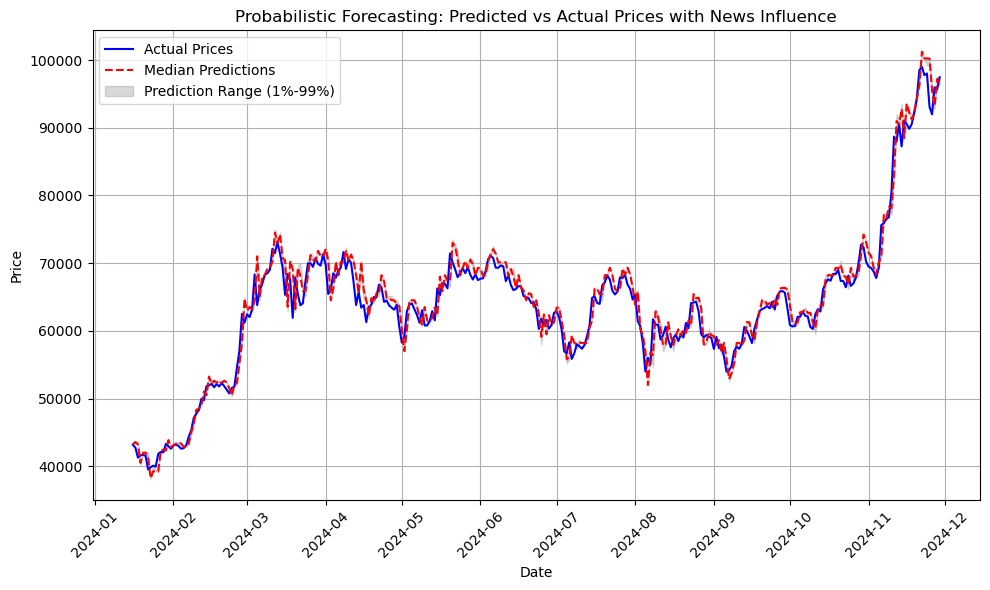

Root Mean Squared Error (RMSE): 2008.2004
Out-of-Sample R2: 0.9647


In [14]:
rmse, r2 = plot_predictions_and_compute_metrics_probabilistic(predictions_df, asset_symbol, f"{asset_symbol}_predictions_chart_3.3.png")

### Test to check if ollama is working.

In [ ]:
response = ollama.chat(
    model="llama3.1",
    messages=[
        {"role": "system", "content": "You are a financial forecasting assistant."},
        {"role": "user", "content": "What is square of 2"}
    ]
)
response_content = response["message"]["content"]
match = re.search(r"[\$]?[0-9,]+\.?[0-9]*", response_content)
print(response_content)
if match:
    print (float(match.group().replace(",", "").replace("$", "")))

In [ ]:
predictions_df.columns

In [ ]:
correction_scaling = (predictions_df.iloc[:,1:].values>1000)*0.01 + (predictions_df.iloc[:,1:].values<1000)

In [ ]:
correction_scaling

In [ ]:
correct_values = predictions_df.iloc[:,1:].values * correction_scaling

In [ ]:
correct_df = pd.DataFrame(data = correct_values, columns = predictions_df.columns[1:])
correct_df['Date'] = predictions_df['Date'].values

In [ ]:
rmse, r2 = plot_predictions_and_compute_metrics_probabilistic(correct_df)

In [ ]:
4%3